# 蛋白质和 DNA 结合位点定位
# 多重检验问题
$5\%$ 水平的假设检验, 在 $100$ 次假设检验中, 至少出现一次错误(错误地拒绝原假设)的概率为
$$
    1-(1-0.05)^{100}\approx0.994
$$
当一个数据集有多词假设检验时, 需要做多重假设检验校正.

## 控制错误的方法
### $Bonferroni\ Correction$
改变显著性水平 $\alpha = \frac{\alpha}{m}$ 得到新的显著性水平, $reject\ H_i\ if \ p_i\leq \alpha$

> 例如, 如果检验 $1000$ 次, 就将阈值($\frac{\alpha}{m}$) 设定为 $\frac{5\%}{1000}$, 即使检验 $1000$ 次, 出现错误的概率还是保持在 $N\times 1000 = 5\%$
> 该方法虽然简单, 但是检验过于严格, 导致最后找不到显著表达的的蛋白(假阴性)

### False Discovery Rate (FDR)
对于 $m$ 次假设检验 $H_1,H_2,\cdots,H_m$, 得到 P 值: $P_1,P_2,\cdots,P_m$, 将 P 值从小到大进行排序: $P_{(1)},P_{(2)},\cdots,P_{(m)}$
对于给定的 $\overline{\alpha}$, 找到满足条件 $P{(k)}\leq \frac{k}{m}\overline{\alpha}$ 的最大 $k$ 值
然后拒绝 $H_i,i=1,2,\cdots,k$ 这些原假设

> 相对 Bonferroni 来说, FDR 用比较温和的方法对 $p$ 值进行了校正. 其试图在假阳性和假阴性间达到平衡, 将假/真阳性比例控制到一定范围之内, 例如, 如果检验 $1000$ 次, 我们设定的阈值为 $0.05(5\%)$, 那么无论我们得到多少个差异蛋白, 这些差异蛋白出现假阳性的概率保持在 $5\%$ 之内, 这就叫 $FDR＜5\%$.

### 使用 R 中的 `p.adjust()`
`p.adjust(p, method = p.adjust.methods, n = length(p))`
+ `p` 是多重假设检验的多个 `p` 值
+ `p.adjust.methods` 有: 'holm''hochberg''hommel''bonferroni''BH''BY''fdr''none'

# 实验思路
+ 原假设: 读取位点 `reads` 随机落在基因组上.
+ 分布特征: $B(n,p),\ n\to \infty,\ p\to 0$
    + 近似为泊松分布
    + $$P(x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
+ 计算 $P$ 值
    + $P$ 值越小, 越表明测序 `reads` 落在该 DNA 区间不是随机的, 从而说明蛋白质结合具有偏好性.
+ 注意事项
    + 蛋白质跟 DNA 结合位点具有一定范围, 可能不是单个位点
    + DNA `reads` 具有偏好性不天然等价于结合位点
        + 数据除了随机误差, 还可能具有系统偏好性

## 定位峰
分析数据和曲线特征, 寻找局部最大值

1. 阈值筛选峰: 人为设定, 分位数, 拒绝域临界点
2. 局部极大值筛选峰(原始值找顶点, 如以最大值顶点为中心左右各扩展 75 bp)

### 寻找显著峰的方法
1. 使用局部(或全局)泊松分布计算峰中各剪辑的测序深度出现的概率, 并计算局部(或全局)平均测序深度 $\lambda$ (泊松分布均值)对应的概率值作为总体均值(总体理论概率), 然后将峰作为一个样本跟总体均值相比较
2. 根据测序深度作为观察值做一个样本均数假设检验
3. 根据泊松分布直接计算超过这个峰均值的所有观测值之和, 通过这个累计概率是否小于 $0.05$ 判断是否为显著峰

# 实验过程
## 读取数据与可视化

Warning message in matrix(peakData, ncol = 151, byrow = T):
“data length [16] is not a sub-multiple or multiple of the number of columns [151]”


ERROR: Error in t.test.default(peakDataFrame[, 153], mu = p): not enough 'x' observations


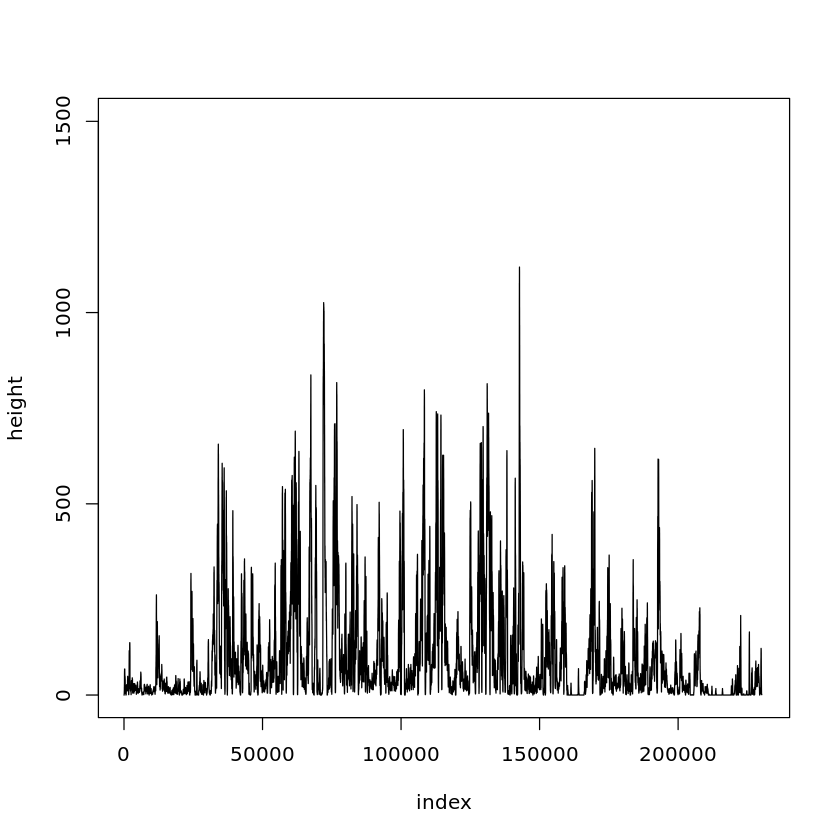

In [1]:
data <- read.table('GSM1016879_WT_ChrI_K4me3.txt', header = F)
x <- data[, 2]
y <- data[, 4]
plot(c(1, 231000), c(1, 1500), type = "n", xlab = "index", ylab = "height")
lines(x, y)
meanOfDepth <- mean(y)
dataSpline <- smooth.spline(x, y)
dataMatrix <- as.matrix(cbind(data[1], data[2]))
peak <- data.frame(0, 0, 0)
for (i in 2:nrow(dataMatrix) - 1) {
  if (dataMatrix[i, 2] >= meanOfDepth) {
    if (dataMatrix[i, 2] > dataMatrix[i - 1, 2]) {
      if (dataMatrix[i, 2] > dataMatrix[i + 1, 2]) {
        peak <- rbind(peak, dataMatrix[i, 1])
      }
    }
  }
}
peak[, 1] <- peak[, 1] - 75
peak[, 1] <- peak[, 3] + 75
peak <- na.omit(peak[peak > 0,])
peakData <- data.frame(0)
for (i in 1:nrow(peak)) {
  for (j in peak[i, 1]:peak[i, 3]) {
    peakData <- rbind(peakData, data[j, 4])
  }
}
peakData <- peakData[peakData > 0,]
peakDataFrame <- data.frame(matrix(peakData, ncol = 151, byrow = T))

peakDataFrame[, 152] <- sum(peakDataFrame[, 1:151]) / 151

lambda <- round(meanOfDepth)
peakDataFrame[, 153] <- dpois(x = round(peakDataFrame[, 152]), lambda = lambda)
p <- dpois(x = lambda, lambda = lambda)
tTest <- t.test(peakDataFrame[, 153], mu = p)
p.adjust(tTest[3], method = "fdr", 1)

p.value 
3.007753e-29

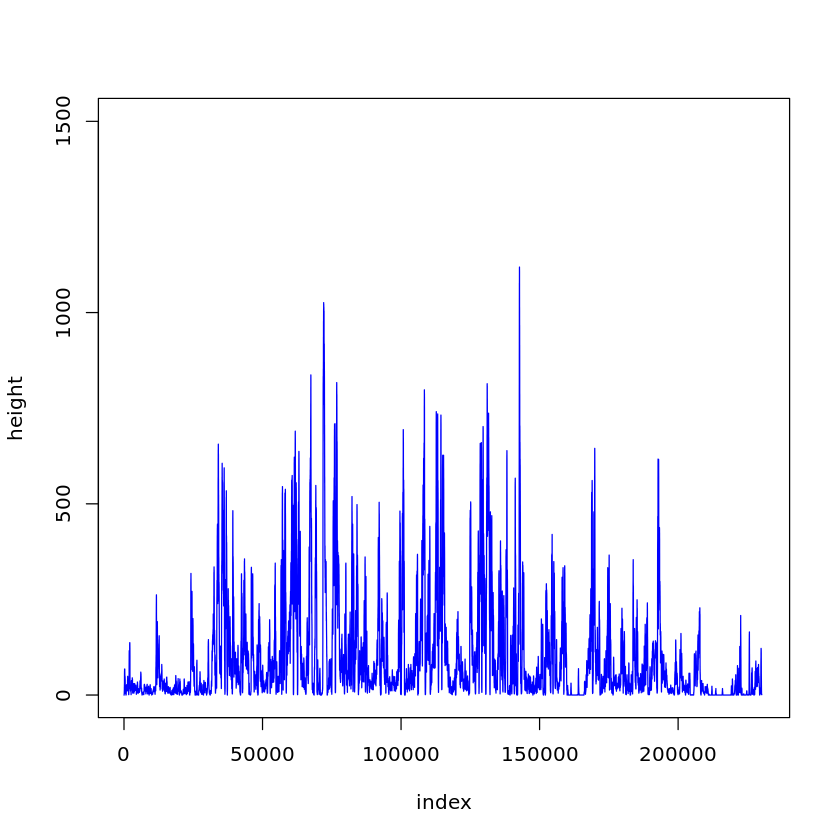

In [16]:
X1 <- read.table('GSM1016879_WT_ChrI_K4me3.txt', header = F)    #读取数据
x <- rep(1:230215)
y <- X1[, 4]
plot(c(1, 231000), c(1, 1500), type = "n", xlab = "index", ylab = "height")
lines(x, y, col = "blue")    #深度折线图
average <- mean(y)        #平均值
data <- smooth.spline(X1[, 2], y)        #将位点和深度进行曲线拟合
d <- as.matrix(data.frame(data[1], data[2]))    #提取拟合的位点和对应数据
dt <- data.frame(0, 0, 0)
for (i in 2:nrow(d) - 1) {        #寻找并提取不小于平均值的峰值位点
  if (d[i, 2] >= average) {
    if (d[i, 2] > d[i - 1, 2]) {
      if (d[i, 2] > d[i + 1, 2]) {
        dt <- rbind(dt, d[i, 1])
      }
    }
  }
}
dt[, 1] <- dt[, 1] - 75            #扩大峰值区，左右+75bp
dt[, 3] <- dt[, 3] + 75
dt <- na.omit(dt[dt > 0,])
t <- data.frame(0)
for (i in 1:nrow(dt)) {            #提取峰值区内数据
  for (n in dt[i, 1]:dt[i, 3]) {
    t <- rbind(t, X1[n, 4])
  }
}
t <- t[t > 0,]      #共有13892个数据
X <- data.frame(matrix(t, ncol = 151, byrow = T))    #将峰值区内数据转换成数据框模型
for (i in 1:nrow(X)) {                #计算局部lambda
  X[i, 152] <- sum(X[i, 1:151]) / 151
}
lambda <- round(average)                #全局lambda
for (i in 1:nrow(X)) {
  X[i, 153] <- dpois(round(X[i, 152]), lambda)    #计算92个局部p值
}
p <- dpois(lambda, lambda)                #计算理论概率

a <- t.test(X[, 153], mu = p)    #对92个局部p值与理论概率进行t检验

p1 <- p.adjust(a[3], method = "fdr", 1)            #多重矫正

p1

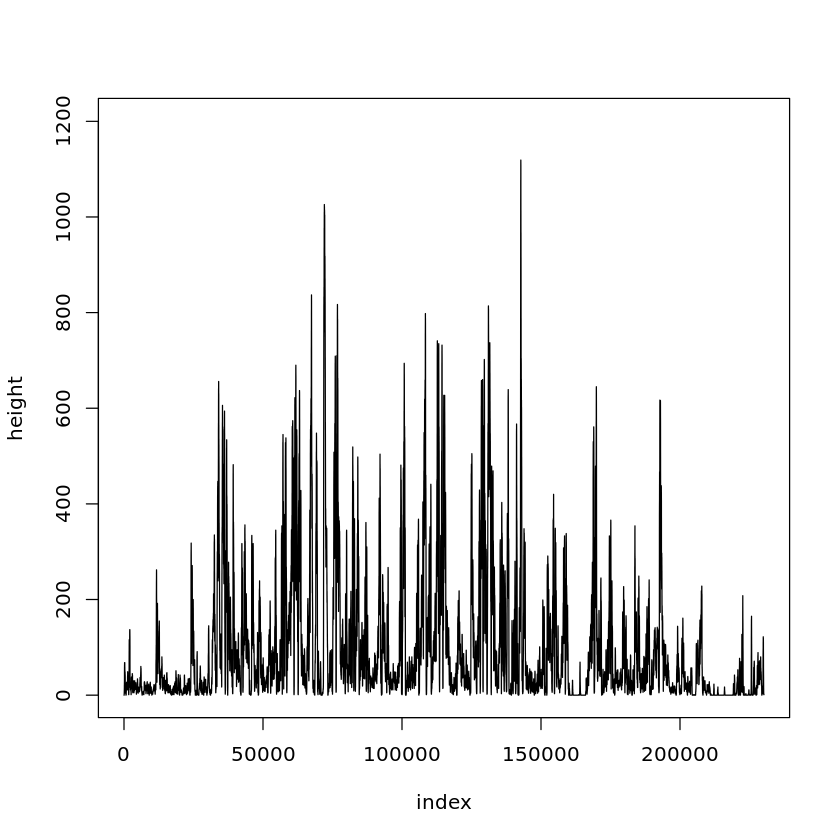

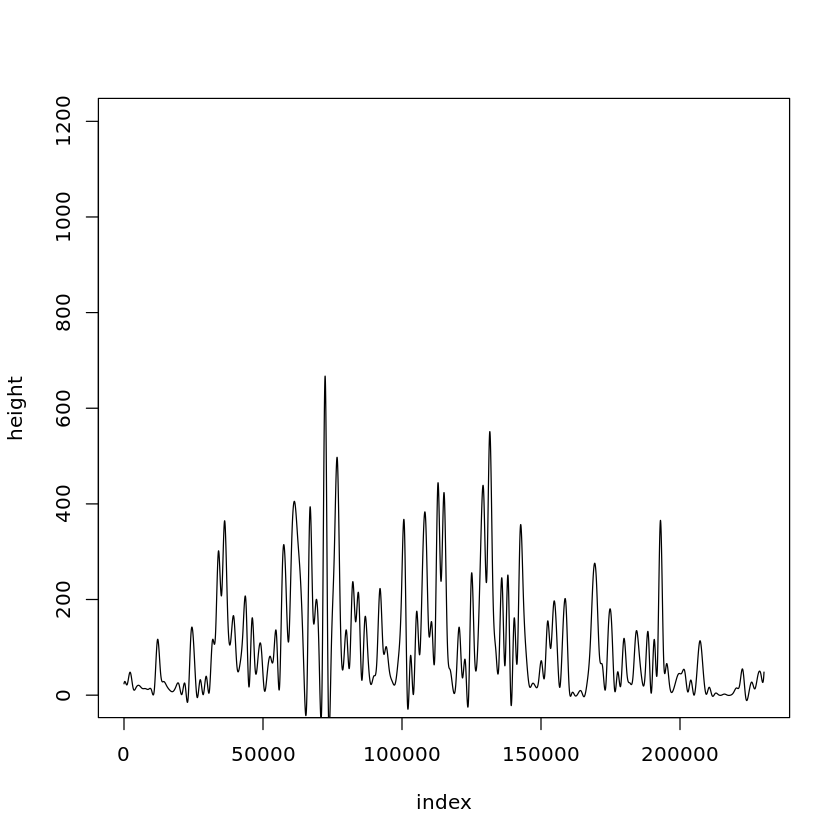

In [4]:
# read data
data <- read.table('GSM1016879_WT_ChrI_K4me3.txt', header = F)
depth <- data[, 4]
pos <- data[, 2]
# visualize
plot(c(1, length(data[, 2])), c(1, 1200), type = "n", xlab = "index", ylab = "height")
lines(pos, depth)
data.spline <- smooth.spline(pos, depth)
plot(c(1, length(data[, 2])), c(1, 1200), type = "n", xlab = "index", ylab = "height")
lines(data.spline)